In [ ]:
from src import simulate as sim
from src import data_prep, analysis
import statsmodels.api as sm
import numpy as np
import pandas as pd
from firthmodels import FirthLogisticRegression
from patsy import dmatrices, dmatrix
from sklearn.model_selection import train_test_split

In [170]:
sim_results = sim.generate_data_for_simulation()

In [171]:
winners_losers_df = data_prep.get_winners_and_losers_dfs(sim_results)

In [210]:
def get_regression_matrix(formula_specification, winners_losers_df_dict):
    winner_dmatrix = dmatrix(formula_specification, winners_losers_df_dict['winner'], return_type='dataframe')
    loser_dmatrix = dmatrix(winner_dmatrix.design_info, winners_losers_df_dict['loser'])
    cov_matrix = (winner_dmatrix - loser_dmatrix)
    cov_matrix = cov_matrix.drop(columns='Intercept')
    cov_matrix = cov_matrix.drop(columns=[col for col in cov_matrix.columns if col.startswith('artist')])
    return cov_matrix

def flip_part_of_matrix_with_matching_outcome(matrix):
    keep, flip = train_test_split(matrix, test_size = 0.5)
    flip = -flip
    return pd.concat([keep, flip]), np.concatenate([np.ones(len(keep)), np.zeros(len(flip))])

In [301]:
get_regression_matrix('model', winners_losers_df)

,model[T.N9cbdyoCyw5tY5NmjHoG96],model[T.Y4Y94noabJL4fkM2qmPCJa],model[T.cGist43H5ckPzet8bpMdWx]
0,-1.0,0.0,0.0
1,0.0,0.0,-1.0
2,0.0,1.0,0.0
3,-1.0,0.0,0.0
4,0.0,0.0,1.0
...,...,...,...
955,0.0,0.0,-1.0
956,0.0,-1.0,0.0
957,1.0,0.0,0.0
958,0.0,0.0,-1.0


In [211]:
formula_specifications = {
    'basic': 'is_ai',
    'basic_across_artists': 'is_ai:artist',
    'model': 'model',
    'model_across_artists': 'model:artist'
}

In [212]:
for k, v in formula_specifications.items():
    cov_matrix = get_regression_matrix(formula_specifications[k], winners_losers_df)
    print(k, np.linalg.matrix_rank(cov_matrix), len(cov_matrix.columns))
    print(cov_matrix.columns)

basic 1 1
Index(['is_ai[T.True]'], dtype='object')
basic_across_artists 4 4
Index(['is_ai[T.True]:artist[art~3tLp5ju2MwEPGdSzc6MWrG]',
       'is_ai[T.True]:artist[art~Cxx79YRgDtiLf8uonmb58r]',
       'is_ai[T.True]:artist[art~gyPbfx63M9umrCQpYqkeMS]',
       'is_ai[T.True]:artist[art~kNhKhjE8yCb7BiGD38Sz5S]'],
      dtype='object')
model 3 3
Index(['model[T.N9cbdyoCyw5tY5NmjHoG96]', 'model[T.Y4Y94noabJL4fkM2qmPCJa]',
       'model[T.cGist43H5ckPzet8bpMdWx]'],
      dtype='object')
model_across_artists 12 12
Index(['model[T.N9cbdyoCyw5tY5NmjHoG96]:artist[art~3tLp5ju2MwEPGdSzc6MWrG]',
       'model[T.Y4Y94noabJL4fkM2qmPCJa]:artist[art~3tLp5ju2MwEPGdSzc6MWrG]',
       'model[T.cGist43H5ckPzet8bpMdWx]:artist[art~3tLp5ju2MwEPGdSzc6MWrG]',
       'model[T.N9cbdyoCyw5tY5NmjHoG96]:artist[art~Cxx79YRgDtiLf8uonmb58r]',
       'model[T.Y4Y94noabJL4fkM2qmPCJa]:artist[art~Cxx79YRgDtiLf8uonmb58r]',
       'model[T.cGist43H5ckPzet8bpMdWx]:artist[art~Cxx79YRgDtiLf8uonmb58r]',
       'model[T.N9cbdyoC

In [219]:
# print(get_regression_matrix(formula_specifications['basic'], winners_losers_df))
def logistic_model_for_ai_human_comparison(hypothesis, winners_losers_df):
    X = get_regression_matrix(formula_specifications[hypothesis], winners_losers_df)
    X, y = flip_part_of_matrix_with_matching_outcome(X)

    # Standard logistic regression
    mod = sm.Logit(y, X)
    res = mod.fit(disp=0)
    logit_results = pd.concat([res.params.rename('logit_coef').to_frame(), res.conf_int().rename(columns={0:'logit_lower', 1:'logit_upper'}), res.pvalues.rename('logit_p').to_frame()], axis = 1)

    # Firth regression (deals with some nasty scenarios)
    firth_model = FirthLogisticRegression(fit_intercept=False).fit(X, y)
    firth_results = pd.concat([pd.Series(firth_model.coef_, name='firth_coef'), pd.DataFrame(firth_model.conf_int()).rename(columns={0:'firth_lower', 1:'firth_upper'}), pd.Series(firth_model.pvalues_, name = 'firth_p')], axis = 1)
    firth_results.index = logit_results.index

    return res, pd.concat([logit_results, firth_results], axis = 1)

def multinomial_model_for_ai_human_comparison(hypothesis, winners_losers_df):
    X = get_regression_matrix(formula_specifications[hypothesis], winners_losers_df)
    mod = sm.MNLogit(sim_results['outcomes']['reason'], X)
    res = mod.fit(disp=0)
    conf_int = res.conf_int()
    ind = conf_int.index
    coef = res.params.unstack().rename('coef').to_frame()
    coef.index = ind
    p = res.pvalues.unstack().rename('p').to_frame()
    p.index = ind
    return res, pd.concat([coef, conf_int, p], axis = 1)

In [223]:
model, res = logistic_model_for_ai_human_comparison('model', winners_losers_df)
res
# return pd.concat([res.params.rename('logit_coef').to_frame(), res.conf_int().rename(columns={0:'logit_lower', 1:'logit_upper'}), res.pvalues.rename('logit_p').to_frame()], axis = 1)

,logit_coef,logit_lower,logit_upper,logit_p,firth_coef,firth_lower,firth_upper,firth_p
model[T.N9cbdyoCyw5tY5NmjHoG96],-1.049220,-1.299202,-0.799237,1.930834e-16,-1.045320,-1.294680,-0.795961,2.100202e-16
model[T.Y4Y94noabJL4fkM2qmPCJa],-0.862224,-1.102035,-0.622412,1.829514e-12,-0.859194,-1.098484,-0.619903,1.958286e-12
model[T.cGist43H5ckPzet8bpMdWx],-0.730888,-0.964814,-0.496961,9.138497e-10,-0.728403,-0.961864,-0.494943,9.647068e-10


In [ ]:
def test_for_ai_difference(logistic_model_with_basic_setup):
    return logistic_model.pvalues.iloc[0]

In [259]:
test_for_ai_difference(logistic_model_for_ai_human_comparison('basic', winners_losers_df)[0])

np.float64(3.351435320543131e-35)

In [287]:
def test_for_coefficient_equality(logistic_model, terms):
    return logistic_model.wald_test(','.join([f'({terms[i]} = {terms[i+1]})' for i in range(len(terms) - 1)]), scalar=True).pvalue

def test_for_ai_model_differences(logistic_model):
    names = logistic_model.model.exog_names
    return test_for_coefficient_equality(logistic_model, names)

def test_for_ai_model_differences_across_artists(logistic_model):
    names = logistic_model.model.exog_names
    split_names = list(map(lambda el: el.split(':'), names))
    res_dict = {}
    for artist in np.unique(list(zip(*split_names))[1]):
        vars = [var_name for var_name in names if var_name.split(':')[1] == artist]
        res_dict[artist] = test_for_coefficient_equality(mod, vars)
    return pd.Series(res_dict)

def test_for_coefficient_non_zero(logistic_model, terms):
    return logistic_model.wald_test(','.join([f'({term} = 0)' for term in terms]), scalar=True).pvalue

def test_for_ai_model_nonzero(logistic_model):
    names = logistic_model.model.exog_names
    return test_for_coefficient_non_zero(logistic_model, names)

def test_for_ai_model_nonzero_across_artists(logistic_model):
    names = logistic_model.model.exog_names
    split_names = list(map(lambda el: el.split(':'), names))
    res_dict = {}
    for artist in np.unique(list(zip(*split_names))[1]):
        vars = [var_name for var_name in names if var_name.split(':')[1] == artist]
        res_dict[artist] = test_for_coefficient_non_zero(mod, vars)
    return pd.Series(res_dict)

In [304]:
mod = multinomial_model_for_ai_human_comparison('basic', winners_losers_df)[0]
mod

In [311]:
pd.concat([sim_results['outcomes']['reason'], sim_results['outcomes']['ai_win']], axis =1 ).value_counts()
# .groupby(
#     by=['ai_win', 'reason']
# ).count

reason  ai_win
1       0         163
0       0         135
3       0         113
5       0         113
4       0          87
2       0          67
3       1          65
5       1          62
4       1          48
2       1          46
0       1          35
1       1          26
Name: count, dtype: int64

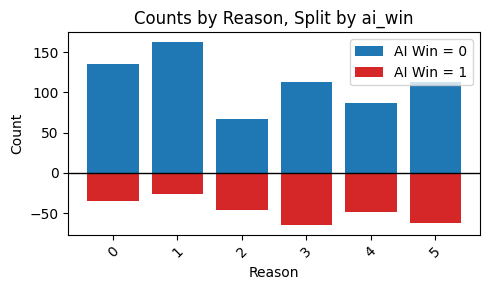

In [314]:
import pandas as pd
import matplotlib.pyplot as plt

# Build dataframe
df = pd.concat(
    [sim_results['outcomes']['reason'], sim_results['outcomes']['ai_win']],
    axis=1
).rename(columns={0: 'reason', 1: 'ai_win'})  # optional renaming

# Count occurrences
counts = df.groupby(['reason', 'ai_win']).size().unstack(fill_value=0)

# Extract the two series
win0 = counts[0]     # ai_win = 0
win1 = counts[1]     # ai_win = 1

# Make win1 negative so bars go downward
win1_neg = -win1

# Plot
fig, ax = plt.subplots(figsize=(5, 3))

ax.bar(win0.index, win0, label="AI Win = 0", color="tab:blue")
ax.bar(win1.index, win1_neg, label="AI Win = 1", color="tab:red")

# Formatting
ax.axhline(0, color='black', linewidth=1)
ax.set_ylabel("Count")
ax.set_xlabel("Reason")
ax.set_title("Counts by Reason, Split by ai_win")
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [305]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                 reason   No. Observations:                  960
Model:                        MNLogit   Df Residuals:                      955
Method:                           MLE   Df Model:                            0
Date:                Thu, 11 Dec 2025   Pseudo R-squ.:                0.008768
Time:                        22:38:01   Log-Likelihood:                -1690.9
converged:                       True   LL-Null:                       -1705.9
Covariance Type:            nonrobust   LLR p-value:                       nan
=================================================================================
     reason=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
is_ai[T.True]    -0.2005      0.104     -1.924      0.054      -0.405       0.004
---------------------------------------------------------------------------------
     reason=2       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
is_ai[T.True]     0.5102      0.114      4.474      0.000       0.287       0.734
---------------------------------------------------------------------------------
     reason=3       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
is_ai[T.True]     0.3251      0.112      2.902      0.004       0.106       0.545
---------------------------------------------------------------------------------
     reason=4       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
is_ai[T.True]     0.3859      0.113      3.423      0.001       0.165       0.607
---------------------------------------------------------------------------------
     reason=5       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
is_ai[T.True]     0.3051      0.112      2.729      0.006       0.086       0.524
=================================================================================
"""

In [315]:
mod.predict()

array([[0.20153945, 0.24629126, 0.12099694, 0.14560532, 0.13701893,
        0.1485481 ],
       [0.20153945, 0.24629126, 0.12099694, 0.14560532, 0.13701893,
        0.1485481 ],
       [0.12994236, 0.10633147, 0.21643946, 0.17985959, 0.19113062,
        0.17629651],
       ...,
       [0.12994236, 0.10633147, 0.21643946, 0.17985959, 0.19113062,
        0.17629651],
       [0.20153945, 0.24629126, 0.12099694, 0.14560532, 0.13701893,
        0.1485481 ],
       [0.20153945, 0.24629126, 0.12099694, 0.14560532, 0.13701893,
        0.1485481 ]], shape=(960, 6))

In [ ]:
sim_results['outcomes']['reason'], winners_losers_df[]

0      0
1      4
2      2
3      1
4      5
      ..
955    1
956    1
957    5
958    1
959    3
Name: reason, Length: 960, dtype: int64

In [294]:
mod.pred_table()

array([[  0., 135.,  35.,   0.,   0.,   0.],
       [  0., 163.,  26.,   0.,   0.,   0.],
       [  0.,  67.,  46.,   0.,   0.,   0.],
       [  0., 113.,  65.,   0.,   0.,   0.],
       [  0.,  87.,  48.,   0.,   0.,   0.],
       [  0., 113.,  62.,   0.,   0.,   0.]])

In [293]:
np.exp(mod.params)

,0,1,2,3,4
is_ai[T.True],0.818297,1.665657,1.384149,1.470888,1.356729


In [286]:
mod.wald_test("(model[T.N9cbdyoCyw5tY5NmjHoG96] = 0), (model[T.Y4Y94noabJL4fkM2qmPCJa] = 0), (model[T.cGist43H5ckPzet8bpMdWx])")

/Users/daxmavy/oxford/art/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[154.8313858]], p-value=2.390229451820806e-33, df_denom=3>

Hypothesis:
R1:
1. AI different ability to humans (is beta parameter stat sig) done
2. Difference between models: done; non-zero coefficients of models: done
3. Across artists: done

R3:
1. 

Things to check:
1. Comparison between model abilities